### Indore City House Price Prediction (Linear Regression)
##### Objective: Predict the median resale value of houses in Indore

log(MEDV) ~ CRIM + RIVER + NOC + RD + DIS + PTRATIO + RAD + B + LSTAT (-ZN,-INDUS,-AGE, -TAX)

### Data fields
1. CRIM: per capita crime rate
2. ZN: the proportion of residential land zoned for lots larger than 25,000 sq.ft.
3. INDUS: the proportion of non-retail business acres per town.
4. RIVER_FLG: River Dummy Var (this is equal to 1 if tract bounds river; 0 otherwise)
5. nitric oxides concentration: the nitric oxides concentration (parts per 10 million)
6. #rooms/dwelling: the average number of rooms per dwelling
7. AGE: the proportion of owner-occupied units built prior to 1940
8. DIS: the weighted distances to five employment centers of the town
9. RAD: the index of accessibility to radial highways
10. TAX: the full-value property-tax rate per INR 10 millions (1 crores)
11. PTRATIO: the pupil-teacher ratio by area 
12. B: calculated as 1000(Bk — 0.63)², where Bk is the proportion of people living is slums in the area
13. LSTAT: This is the percentage lower status and income of the population
14. MEDV: This is the median value of owner-occupied homes in INR millions (10 lakhs)

- Each record in the database describes an Indore suburb.

# LIBRARIES IMPORT

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indore-city-house-price-predection/IndoreHP_Sample.csv
/kaggle/input/indore-city-house-price-predection/IndoreHP_Test.csv
/kaggle/input/indore-city-house-price-predection/IndoreHP_Train.csv


In [2]:
import numpy as np
import pandas as pd 
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor #to calculate VIF values
from scipy.stats import pearsonr #TO CHECK INDIVIDUAL CORRELATIONS
from sklearn.model_selection import train_test_split


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# BIRD'S EYE VIEW

In [4]:
train_df = pd.read_csv('../input/indore-city-house-price-predection/IndoreHP_Train.csv')
test_df = pd.read_csv('../input/indore-city-house-price-predection/IndoreHP_Test.csv')

In [5]:
print("Shape of Train Dataset ",train_df.shape)
print("Shape of Test Dataset ",test_df.shape)

Shape of Train Dataset  (350, 15)
Shape of Test Dataset  (102, 14)


- Train dataset has one row more that Test, which is expected. 

In [6]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,102.0,450.500000,29.588849,400.000000,425.250000,450.500000,475.750000,501.000000
CRIM,102.0,4.931723,3.267641,0.017432,2.780589,5.167552,7.653062,10.464867
ZN,102.0,4.019608,16.665599,0.000000,0.000000,0.000000,0.000000,90.000000
INDUS,102.0,16.663465,5.105513,1.312500,17.376000,17.919000,18.643000,28.849600
RIVER_FLG,102.0,0.078431,0.270177,0.000000,0.000000,0.000000,0.000000,1.000000
nitric oxides concentration,102.0,0.642003,0.088789,0.393600,0.584730,0.658350,0.710400,0.800800
#rooms/dwelling,102.0,6.164373,0.654614,3.454170,5.870647,6.184500,6.584888,9.219000
AGE,102.0,81.550480,20.207523,18.685000,75.552000,87.962000,95.604500,104.265000
DIS,102.0,2.777745,2.038463,1.107008,1.860283,2.296854,2.741106,11.520175
RAD,102.0,19.284314,8.593547,1.000000,24.000000,24.000000,24.000000,24.000000


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,350.0,175.500000,101.180532,1.00000,88.250000,175.500000,262.750000,350.000000
CRIM,350.0,0.404963,0.651082,0.00613,0.058786,0.132758,0.411469,4.261296
ZN,350.0,15.257143,25.607566,0.00000,0.000000,0.000000,22.000000,100.000000
INDUS,350.0,8.436498,6.044201,0.45080,4.019625,6.448000,10.263600,26.676000
RIVER_FLG,350.0,0.077143,0.267200,0.00000,0.000000,0.000000,0.000000,1.000000
nitric oxides concentration,350.0,0.510684,0.103476,0.37430,0.441527,0.489425,0.542917,0.914550
#rooms/dwelling,350.0,6.396922,0.719591,4.72896,5.931550,6.276270,6.746752,8.986750
AGE,350.0,60.867446,28.566625,2.87100,35.149500,62.019500,88.151000,105.000000
DIS,350.0,4.402082,1.971886,1.25552,2.723105,4.108295,5.750662,9.555104
RAD,350.0,4.482857,1.607109,1.00000,4.000000,4.000000,5.000000,8.000000


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           102 non-null    int64  
 1   CRIM                         102 non-null    float64
 2   ZN                           102 non-null    int64  
 3   INDUS                        102 non-null    float64
 4   RIVER_FLG                    102 non-null    int64  
 5   nitric oxides concentration  102 non-null    float64
 6   #rooms/dwelling              102 non-null    float64
 7   AGE                          102 non-null    float64
 8   DIS                          102 non-null    float64
 9   RAD                          102 non-null    int64  
 10  TAX                          102 non-null    int64  
 11  PTRATIO                      102 non-null    float64
 12  B                            102 non-null    float64
 13  LSTAT               

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           350 non-null    int64  
 1   CRIM                         350 non-null    float64
 2   ZN                           350 non-null    float64
 3   INDUS                        350 non-null    float64
 4   RIVER_FLG                    350 non-null    int64  
 5   nitric oxides concentration  350 non-null    float64
 6   #rooms/dwelling              350 non-null    float64
 7   AGE                          350 non-null    float64
 8   DIS                          350 non-null    float64
 9   RAD                          350 non-null    int64  
 10  TAX                          350 non-null    int64  
 11  PTRATIO                      350 non-null    float64
 12  B                            350 non-null    float64
 13  LSTAT               

- no NaNs: So no need for missing values treatment
- Categorical data already encoded. So need of Data Encoding
- Names of troublesome attributes need to be changed. We shouldn't have spaces and the attribute names should not begin with special characters
    - "nitric oxides concentration" to "NOC"
    - "#rooms/dwelling" to "RD"
- Let us check for duplicated rows.

In [10]:
#Checking Duplicates
train_df.duplicated().sum()

0

- No duplicates. Yay.


# ATTRIBUTE NAME TREATMENT
- Since we are permanently changing the names of two attributes of Train data, we should do the same for Test data

In [11]:
train_df.rename(columns = {"nitric oxides concentration":"NOC", "#rooms/dwelling":"RD", 'RIVER_FLG':'RIVER' }, inplace = True)
test_df.rename(columns = {"nitric oxides concentration":"NOC", "#rooms/dwelling":"RD", 'RIVER_FLG':'RIVER'}, inplace = True)

In [12]:
#fetching a list of features.
#use whenever needed
train_df.columns

Index(['ID', 'CRIM', 'ZN', 'INDUS', 'RIVER', 'NOC', 'RD', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO  ', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

- The name PTRATIO has spaces. So renaming it as simple PTR

In [13]:
train_df.rename(columns = {'PTRATIO  ':'PTR'}, inplace = True)
test_df.rename(columns = {'PTRATIO  ':'PTR'}, inplace = True)

### After treatment

In [14]:
train_df

,ID,CRIM,ZN,INDUS,RIVER,NOC,RD,AGE,DIS,RAD,TAX,PTR,B,LSTAT,MEDV
0,1,0.006130,18.0,2.3562,0,0.51648,6.31200,64.548,4.090000,1,296,15.3,404.8380,4.8804,24.720
1,2,0.027037,0.0,6.8579,0,0.48776,6.74205,81.267,5.165784,2,242,17.8,416.7450,9.4142,22.680
2,3,0.028109,0.0,6.9286,0,0.45962,7.40055,61.711,4.967100,2,242,17.8,396.7583,4.0703,36.435
3,4,0.033341,0.0,2.2454,0,0.44426,7.34790,45.342,6.001578,3,222,18.7,406.4689,2.9400,34.736
4,5,0.072502,0.0,2.1800,0,0.47632,7.14700,53.658,5.819712,3,222,18.7,388.9620,5.3833,38.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,346,0.032687,0.0,4.4778,0,0.45526,5.95386,47.530,7.933464,3,352,18.8,401.0656,10.4247,16.800
346,347,0.060388,0.0,4.3900,0,0.45084,5.78004,54.915,8.254008,3,352,18.8,346.3795,12.9234,17.372
347,348,0.019261,85.0,3.9840,0,0.42042,6.77664,26.592,8.279241,4,351,17.9,408.1272,6.1056,22.638
348,349,0.015010,80.0,2.0703,0,0.44370,6.76770,30.888,8.761200,4,280,17.0,398.7588,5.7504,23.520


- our target variable is MEDV (median value of owner-occupied homes in INR millions)

# DATA TRAINING WITH LINEAR REGRESSION 
## And interpretation of results with OLS
- As mentioned in the beginning, I will solely focus on Linear Regression
- Now let us put our data through a linear model and check the results

### Splitting target attribute and independent attribute

In [15]:
X = train_df.drop(['MEDV'], axis = 1)
y = train_df['MEDV']

### Splitting to training and testing data 

In [16]:
# I use model_selection class from sklearn library
# train_df has been split into ratio 0.7/0.3
#random_state has been kept at 4 (seed)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 4)

## ITERATION I

In [17]:
#give summary stats of Linear Regression with OLS class of statsmodule library

sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1025.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):                   4.08e-199
Time:                        23:09:54   Log-Likelihood:                         -644.83
No. Observations:                 245   AIC:                                      1318.
Df Residuals:                     231   BIC:                                      1367.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ID            -0.0056      0.003     -2.168      0.031      -0.011      -0.001
CRIM           0.7079      0.552      1.283      0.201      -0.379       1.795
ZN             0.0188      0.014      1.369      0.172      -0.008       0.046
INDUS          0.0169      0.058      0.291      0.771      -0.097       0.131
RIVER          1.0350      0.867      1.194      0.234      -0.673       2.743
NOC           -8.6061      3.772     -2.282      0.023     -16.037      -1.175
RD             7.9147      0.348     22.774      0.000       7.230       8.599
AGE           -0.0407      0.013     -3.124      0.002      -0.066      -0.015
DIS           -1.1593      0.190     -6.114      0.000      -1.533      -0.786
RAD            0.0989      0.166      0.597      0.551      -0.227       0.425
TAX           -0.0124      0.004     -3.099      0.002      -0.020      -0.005
PTR           -0.7678      0.110     -6.955      0.000      -0.985      -0.550
B              0.0153      0.005      2.926      0.004       0.005       0.026
LSTAT         -0.2012      0.057     -3.504      0.001      -0.314      -0.088
==============================================================================
Omnibus:                       34.901   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.835
Skew:                           0.844   Prob(JB):                     3.37e-12
Kurtosis:                       4.525   Cond. No.                     9.04e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. A high value of F statistic, with a very low p-value  implies that the null hypothesis can be rejected. This means there is a potential relationship between the predictors and the outcome.
    - F stat= 1025; & Prob (F-statistic): 4.08e-199 means we are in the right direction
2. R-squared (R²) measures the proportion of variability in the outcome that can be explained by the model, and is almost always between 0 and 1; the higher the value, the better the model is able to explain the variability in the outcome. However, increase in number of predictors mostly results in an increased value of R² due to inflation of R-squared. Adjusted R-squared adjusts the value of R² to avoid this effect. A high value of adjusted R²  shows that more than (adjusted R²)% of the variance in the data is being explained by the model.
    - Mod R-sq = 0.983: decently high for the current model
3. Multicollinearity - two or more predictors are highly related to each other, and hence one predictor can be used to predict the value of the other. The problem with multi-collinearity is that it can make it harder to estimate the individual effects of the predictors on the outcome. It can be detected using the Variance Inflation Factor (VIF). VIF of any predictor is the ratio of variance of its estimated coefficient in the full model to the variance of its estimated coefficient when fit on the outcome only by itself (as in simple linear regression).  A VIF of 1 indicates no presence of multicollinearity. Usually, a VIF value of above 5 or 10 is taken as an indicator of multicollinearity. 

In [18]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

   feature         VIF
0       ID    5.504093
1     CRIM    4.280310
2       ZN    3.609306
3    INDUS    7.795248
4    RIVER    1.189373
5      NOC   80.333953
6       RD  102.245593
7      AGE   15.873553
8      DIS   16.897950
9      RAD   13.079837
10     TAX   33.579860
11     PTR   78.080082
12       B   80.694241
13   LSTAT   10.215764


### ZN
- Let's focus on ZN
- ZN: 0.0188, 0.014	1.369, 0.172, -0.008, 0.046
- It is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
- Intuitively it might affect the MEDV of high-price houses, but not the low ones. Not very useful information.
- ZN has low B beta coefficient (0.0188), and high P value (0.172). So, it has low impact on Model and is statistically insignificant
- So, can be dropped. Let us plot a histogram

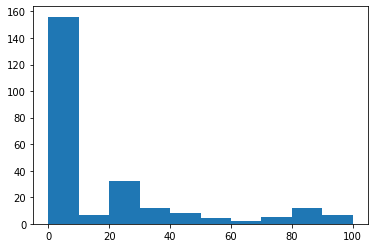

In [19]:
ax = plt.hist(X_train['ZN'])

- Highly skewed.
- Most of ZN values are 0, which is expected because bigger lots are usually used for commercial activities. 
- All the facts suggest its removal.

In [20]:
#removing it from all concerned datasets

X_train.drop(['ZN'],axis=1,inplace=True)
X_test.drop(['ZN'],axis=1,inplace=True)
test_df.drop(['ZN'],axis=1,inplace=True)

## ITERATION II

In [21]:
sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1100.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):                   3.06e-200
Time:                        23:09:56   Log-Likelihood:                         -645.82
No. Observations:                 245   AIC:                                      1318.
Df Residuals:                     232   BIC:                                      1363.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ID            -0.0051      0.003     -1.994      0.047      -0.010   -6.18e-05
CRIM           0.6897      0.553      1.248      0.213      -0.399       1.779
INDUS          0.0056      0.058      0.098      0.922      -0.108       0.119
RIVER          1.0603      0.868      1.221      0.223      -0.650       2.771
NOC           -8.7662      3.777     -2.321      0.021     -16.208      -1.325
RD             8.0491      0.334     24.099      0.000       7.391       8.707
AGE           -0.0427      0.013     -3.298      0.001      -0.068      -0.017
DIS           -1.0447      0.170     -6.129      0.000      -1.380      -0.709
RAD            0.0113      0.153      0.074      0.941      -0.290       0.313
TAX           -0.0106      0.004     -2.801      0.006      -0.018      -0.003
PTR           -0.8281      0.101     -8.165      0.000      -1.028      -0.628
B              0.0152      0.005      2.907      0.004       0.005       0.025
LSTAT         -0.1924      0.057     -3.366      0.001      -0.305      -0.080
==============================================================================
Omnibus:                       32.027   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.273
Skew:                           0.806   Prob(JB):                     8.95e-11
Kurtosis:                       4.392   Cond. No.                     9.03e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Condition number has gone down. But not so much.

In [22]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)

   feature        VIF
0       ID   5.399192
1     CRIM   4.277815
2    INDUS   7.639196
3    RIVER   1.188834
4      NOC  80.256629
5       RD  94.088252
6      AGE  15.662619
7      DIS  13.600910
8      RAD  11.123945
9      TAX  30.049822
10     PTR  65.647742
11       B  80.685414
12   LSTAT  10.089235


VIF values have gone down. But not so much.

### INDUS
- Let us shift our focus to INDUS, with a low coef of 0.0056 and high p-value of 0.922. (INDUS: 0.0056,0.058,0.098,0.922,-0.108,0.119)
- It is the proportion of non-retail business acres per region of Indore.
- Even intuitively it is not a major factor deciding the MEDV prices. 
- We don't care about non-retail business centres around us while setting the residential houses unless they are industries. It would be interesting to check its correlation with NOC, though.

In [23]:
pearsonr(X_train['INDUS'], X_train['NOC'])

(0.6696418868819148, 3.0626898552105843e-33)

In [24]:
pearsonr(X_train['INDUS'], X_train['DIS'])

(-0.6060611078596756, 5.859615508258203e-26)

- As it turns out, it indeed has a high positive correlation with NOC (0.67), indicating presence of factories 
- So even though we remove it, NOC will take care of its 'presence' in the model, which cannot be removed because of its very high be coefficient values (8.7)
- Another point is also the negative high correlation of INDUS with DIS (the weighted distances to five employment centers of the town), which is expected because highly industrialized places will be great employment centres.
- In sum, we can remove the INDUS feature without guilt.

In [25]:
X_train.drop(['INDUS'],axis=1,inplace=True)
X_test.drop(['INDUS'],axis=1,inplace=True)
test_df.drop(['INDUS'],axis=1,inplace=True)

## ITERATION III

In [26]:
#again checking the summary of OLS values with new dataset
sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1197.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):                   8.69e-202
Time:                        23:09:57   Log-Likelihood:                         -645.82
No. Observations:                 245   AIC:                                      1316.
Df Residuals:                     233   BIC:                                      1358.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ID            -0.0051      0.003     -1.998      0.047      -0.010   -7.13e-05
CRIM           0.6967      0.547      1.274      0.204      -0.381       1.774
RIVER          1.0692      0.862      1.241      0.216      -0.628       2.767
NOC           -8.6909      3.690     -2.355      0.019     -15.960      -1.421
RD             8.0433      0.328     24.520      0.000       7.397       8.690
AGE           -0.0427      0.013     -3.304      0.001      -0.068      -0.017
DIS           -1.0496      0.163     -6.456      0.000      -1.370      -0.729
RAD            0.0085      0.150      0.057      0.955      -0.287       0.304
TAX           -0.0105      0.004     -2.885      0.004      -0.018      -0.003
PTR           -0.8257      0.098     -8.404      0.000      -1.019      -0.632
B              0.0152      0.005      2.911      0.004       0.005       0.025
LSTAT         -0.1919      0.057     -3.381      0.001      -0.304      -0.080
==============================================================================
Omnibus:                       32.236   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.816
Skew:                           0.808   Prob(JB):                     6.82e-11
Kurtosis:                       4.406   Cond. No.                     8.85e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- F stat= 1197; & Prob (F-statistic): 4.08e-199 means we are in the right direction
- Mod R-sq = 0.983: decently high for the current model
- conditional number has gone down to 8850 from 9030. Let us check through VIF:

In [27]:
vif_data = pd.DataFrame()
vif_data["Attribute"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)

   Attribute        VIF
0         ID   5.352096
1       CRIM   4.206740
2      RIVER   1.175777
3        NOC  76.924500
4         RD  91.137419
5        AGE  15.660916
6        DIS  12.427210
7        RAD  10.749174
8        TAX  27.931941
9        PTR  61.871937
10         B  80.587687
11     LSTAT   9.978211


### RAD
- Still a lot of high VIF values. But we cannot just remove the attributes.
- RAD ( The index of accessibility to radial highways) has very low coef value. But it is an ORDINAL categorical variable. We cannot depend only on B values.
- Ofcourse, intuitively, we may think that it may not have very high significance as we do not 'prefer' to live near radial highways of a city, thus increasing the MEDV of price. But of course some of us want accessibility
- Let us draw a box plot with MEDV

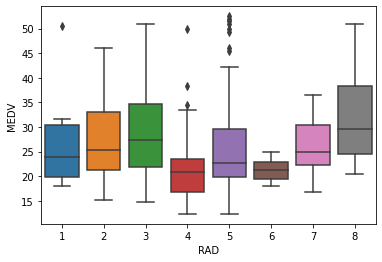

In [28]:
ax = sns.boxplot(x=X_train['RAD'],y=y_train)

- we don't find a strong correlation of MEDV prices and Radial Indices. There is a strong variance wrt prices in both RAD values 3 and 8. And median values remain the same.
- Also, we have a lot of outlier values with RAD=5.
- VIF value is also significant (over 10).
- So, we drop the attribute RAD

In [29]:
#removing it from all concerned datasets

X_train.drop(['RAD'],axis=1,inplace=True)
X_test.drop(['RAD'],axis=1,inplace=True)
test_df.drop(['RAD'],axis=1,inplace=True)

# ITERATION IV

In [30]:
#again checking the summary of OLS values with new dataset
sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1311.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):                   2.35e-203
Time:                        23:09:59   Log-Likelihood:                         -645.82
No. Observations:                 245   AIC:                                      1314.
Df Residuals:                     234   BIC:                                      1352.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ID            -0.0051      0.002     -2.041      0.042      -0.010      -0.000
CRIM           0.6976      0.545      1.279      0.202      -0.377       1.772
RIVER          1.0725      0.858      1.250      0.212      -0.617       2.762
NOC           -8.6929      3.682     -2.361      0.019     -15.946      -1.439
RD             8.0443      0.327     24.613      0.000       7.400       8.688
AGE           -0.0426      0.013     -3.329      0.001      -0.068      -0.017
DIS           -1.0494      0.162     -6.470      0.000      -1.369      -0.730
TAX           -0.0104      0.003     -2.985      0.003      -0.017      -0.004
PTR           -0.8252      0.098     -8.458      0.000      -1.017      -0.633
B              0.0152      0.005      2.917      0.004       0.005       0.025
LSTAT         -0.1922      0.056     -3.414      0.001      -0.303      -0.081
==============================================================================
Omnibus:                       32.207   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.731
Skew:                           0.807   Prob(JB):                     7.12e-11
Kurtosis:                       4.404   Cond. No.                     8.85e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- F stat= 1331; & Prob (F-statistic): 2.35e-203 means we are in the right direction
- Mod R-sq= 0.983: decently high for the current model
- Conditional number= 8850; Same as before. 
- Let us check colliearity through VIF:

In [31]:
vif_data = pd.DataFrame()
vif_data["Attribute"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)

   Attribute        VIF
0         ID   5.088066
1       CRIM   4.202833
2      RIVER   1.170444
3        NOC  76.917589
4         RD  90.866163
5        AGE  15.430387
6        DIS  12.425185
7        TAX  25.930278
8        PTR  61.263909
9          B  80.552409
10     LSTAT   9.864628


### AGE
- Let us look at AGE: the proportion of owner-occupied units built prior to 1940 (in percent)
- A negative correlation of 0.0426 implies higher the proper of 'old' houses in the area, lower would be MEDV. But it comes in the lower bound. 
- Consider its very high p-vsalue coupled with low Beta coefficient value.
- Its VIF value is also high (15.4)
- I think dropping it would be better for overall performance of the model.

In [32]:
#removing it from all concerned datasets

X_train.drop(['AGE'],axis=1,inplace=True)
X_test.drop(['AGE'],axis=1,inplace=True)
test_df.drop(['AGE'],axis=1,inplace=True)

## INTERMEDIATE MODEL VALIDATION
### After Iteration IV

In [33]:
# Model training
lm=LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [34]:
# Model prediction on train data
y_pred = lm.predict(X_train)

In [35]:
# Model Evaluation metrics
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

Adjusted R^2: 0.8415685803293033
MAE: 2.669812263868833
MSE: 11.943758070469062
RMSE: 3.455974257784491


- Decent Adjusted R^2
- High MAE,MSE and RMSE.

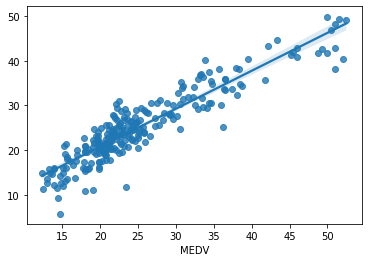

In [36]:
# Actual VS predicted values
ax = sns.regplot(y_train, y_pred)

Also linear predicted line.

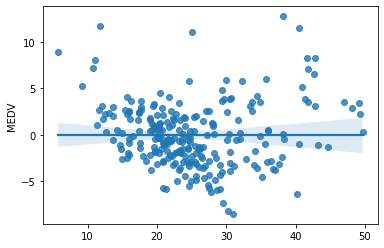

In [37]:
# Checking Heteroskedastcity
#residuals = y_train-y_pred
#plotting residuals against predicted values
#we assume linearity and net sum of errors to be zero

ax = sns.regplot(y_pred,y_train-y_pred)

So net sum of errors is zero.

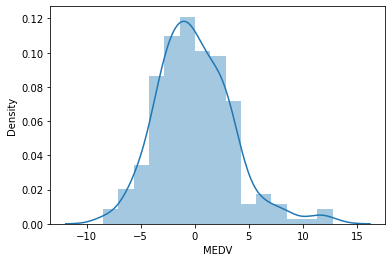

In [38]:
# Checking Normality assumption of errors
ax = sns.distplot(y_train-y_pred)

Almost Linear. We can check the model with the test data given to us.

## MODEL FIT TO SEE RMSE WITH GIVEN TEST DATA

In [39]:
# Predicting Test data with the model
y_testdf_pred = lm.predict(test_df)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [40]:
#feeding output to the hidden test data and check the RMSE value
output = pd.DataFrame({'ID': test_df.ID,
                       'MEDV': y_testdf_pred})
output.to_csv('./submission.csv', index=False)
output

,ID,MEDV
0,400,22.327094
1,401,12.957134
2,402,31.340930
3,403,23.475973
4,404,29.528570
...,...,...
97,497,17.456012
98,498,16.668408
99,499,1.896367
100,500,7.031741


RMSE COMES OUT TO BE 10.02649. We seek a lower value.

## ITERATION V

In [41]:
#again checking the summary of OLS values with new dataset
sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1382.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):                   1.38e-202
Time:                        23:10:03   Log-Likelihood:                         -651.49
No. Observations:                 245   AIC:                                      1323.
Df Residuals:                     235   BIC:                                      1358.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ID            -0.0038      0.003     -1.501      0.135      -0.009       0.001
CRIM           0.6610      0.557      1.187      0.236      -0.436       1.758
RIVER          1.0054      0.876      1.148      0.252      -0.720       2.731
NOC          -10.7252      3.708     -2.893      0.004     -18.030      -3.420
RD             7.7486      0.321     24.123      0.000       7.116       8.381
DIS           -0.7888      0.145     -5.437      0.000      -1.075      -0.503
TAX           -0.0109      0.004     -3.044      0.003      -0.018      -0.004
PTR           -0.8477      0.099     -8.530      0.000      -1.044      -0.652
B              0.0158      0.005      2.989      0.003       0.005       0.026
LSTAT         -0.2636      0.053     -4.959      0.000      -0.368      -0.159
==============================================================================
Omnibus:                       25.633   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.181
Skew:                           0.688   Prob(JB):                     2.29e-08
Kurtosis:                       4.246   Cond. No.                     8.67e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- F stat= 1331; & Prob (F-statistic): 2.35e-203 means we are in the right direction
- Mod R-sq= 0.983: decently high for the current model
- Conditional number= 8850; Same as before. 
- Let us check colliearity through VIF:

In [42]:
vif_data = pd.DataFrame()
vif_data["Attribute"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)

  Attribute        VIF
0        ID   4.960277
1      CRIM   4.201126
2     RIVER   1.169798
3       NOC  74.802350
4        RD  84.155158
5       DIS   9.529148
6       TAX  25.895737
7       PTR  60.968427
8         B  80.424706
9     LSTAT   8.432875


In [43]:
X_train.corr()

,ID,CRIM,RIVER,NOC,RD,DIS,TAX,PTR,B,LSTAT
ID,1.000000,-0.131820,0.134656,-0.108518,0.292970,0.144897,-0.129349,-0.287355,0.086231,-0.294080
CRIM,-0.131820,1.000000,0.133733,0.775663,-0.235373,-0.503983,0.420998,-0.230302,-0.468499,0.433177
RIVER,0.134656,0.133733,1.000000,0.120827,0.106687,-0.146680,-0.042980,-0.149553,-0.067280,0.001607
NOC,-0.108518,0.775663,0.120827,1.000000,-0.272531,-0.717283,0.362915,-0.184443,-0.384865,0.515426
RD,0.292970,-0.235373,0.106687,-0.272531,1.000000,0.082274,-0.260591,-0.314704,0.159313,-0.655437
DIS,0.144897,-0.503983,-0.146680,-0.717283,0.082274,1.000000,-0.246958,0.025929,0.236513,-0.359443
TAX,-0.129349,0.420998,-0.042980,0.362915,-0.260591,-0.246958,1.000000,-0.015680,-0.268560,0.252524
PTR,-0.287355,-0.230302,-0.149553,-0.184443,-0.314704,0.025929,-0.015680,1.000000,0.104579,0.212505
B,0.086231,-0.468499,-0.067280,-0.384865,0.159313,0.236513,-0.268560,0.104579,1.000000,-0.206805
LSTAT,-0.294080,0.433177,0.001607,0.515426,-0.655437,-0.359443,0.252524,0.212505,-0.206805,1.000000


### TAX
- My focus now shifts to TAX with a very low beta coefficient and very high VIF.
- It is the full-value property-tax rate per INR 10 millions (1 crores)
- Let us check it distribution.

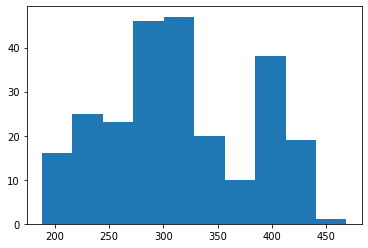

In [44]:
ax = plt.hist(X_train['TAX'])

Its distribution is not also so skewed that some transformation may help.

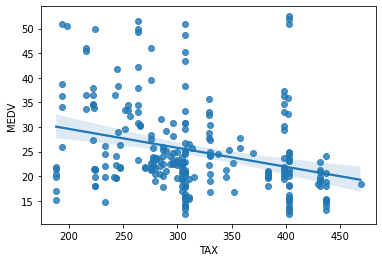

In [45]:
ax = sns.regplot(x=X_train['TAX'],y=y_train)

- Not a very significant contributor to houses prices generally
- As only high median prices houses are affected by it.
- We can drop it without remorse. Let's see anyway

In [46]:
#removing it from all concerned datasets

X_train.drop(['TAX'],axis=1,inplace=True)
X_test.drop(['TAX'],axis=1,inplace=True)
test_df.drop(['TAX'],axis=1,inplace=True)

## INTERMEDIATE MODEL VALIDATION
### After Iteration IV

In [47]:
# Model training
lm=LinearRegression()
lm.fit(X_train, y_train)


# Model prediction on train data
y_pred = lm.predict(X_train)


# Model Evaluation metrics
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

Adjusted R^2: 0.8367755393856438
MAE: 2.6944925778858493
MSE: 12.357679600233997
RMSE: 3.5153491434328394


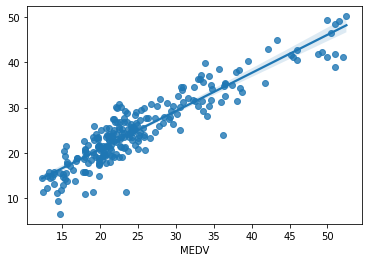

In [48]:
# Actual VS predicted values
ax = sns.regplot(y_train, y_pred)

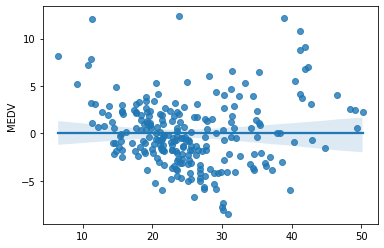

In [49]:
# Checking Heteroskedastcity
ax = sns.regplot(y_pred,y_train-y_pred)

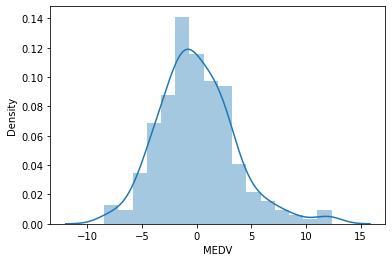

In [50]:
# Checking Normality assumption of errors
ax = sns.distplot(y_train-y_pred)

## MODEL FIT TO SEE RMSE WITH GIVEN TEST DATA

In [51]:
# Predicting Test data with the model
y_testdf_pred = lm.predict(test_df)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

#feeding output to the hidden test data and check the RMSE value
output = pd.DataFrame({'ID': test_df.ID,
                       'MEDV': y_testdf_pred})
output.to_csv('./submission.csv', index=False)
output

,ID,MEDV
0,400,22.706822
1,401,14.648765
2,402,33.221864
3,403,24.579169
4,404,31.610878
...,...,...
97,497,17.696894
98,498,18.011937
99,499,5.997634
100,500,11.204347


## ITERATION VI

In [52]:
#again checking the summary of OLS values with new dataset
sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              1483.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):                   3.25e-202
Time:                        23:10:07   Log-Likelihood:                         -656.23
No. Observations:                 245   AIC:                                      1330.
Df Residuals:                     236   BIC:                                      1362.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ID            -0.0037      0.003     -1.462      0.145      -0.009       0.001
CRIM           0.3266      0.555      0.588      0.557      -0.768       1.421
RIVER          1.2132      0.888      1.366      0.173      -0.537       2.963
NOC          -13.1562      3.684     -3.572      0.000     -20.413      -5.899
RD             7.6885      0.326     23.572      0.000       7.046       8.331
DIS           -0.8507      0.146     -5.822      0.000      -1.139      -0.563
PTR           -0.9138      0.099     -9.262      0.000      -1.108      -0.719
B              0.0153      0.005      2.844      0.005       0.005       0.026
LSTAT         -0.2651      0.054     -4.903      0.000      -0.372      -0.159
==============================================================================
Omnibus:                       24.077   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.158
Skew:                           0.665   Prob(JB):                     1.04e-07
Kurtosis:                       4.174   Cond. No.                     6.81e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- F stat= 1483; & Prob (F-statistic): 3.25e-202 means we are in the right direction
- Mod R-sq= 0.983: decently high for the current model
- Conditional number has reduced from 8850 to 6810 
- Let us check colliearity through VIF:

In [53]:
vif_data = pd.DataFrame()
vif_data["Attribute"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)

  Attribute        VIF
0        ID   4.960186
1      CRIM   4.037620
2     RIVER   1.162685
3       NOC  71.331203
4        RD  83.836441
5       DIS   9.341578
6       PTR  58.056893
7         B  80.343697
8     LSTAT   8.432126


### B
- My attention goes to B with a very low Beta Coefficient and high VIF value (80)
- I do not want to think about removing it. Because it is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people living is slums in the area, thus relates to the density of slum in the locality where the house of concern is located.
- Let me plot its Hist

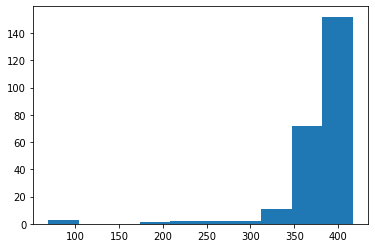

In [54]:
ax = plt.hist(X_train['B'])

- Highly skewed, which might be affected its performance/contribution.
- It is left skwed with all non-zero positive values.
- What happens if we remove it? I want to be sure. So I create dummy datasets, play with them, and check RMSE value with the hidden test dataset, if my RMSE value is lower, I will go ahead and remove it for good.
- But why not check for outliers and other variable also and treat them first to increase the efficiency of our model?

# DEALING WITH OUTLIERS

In [55]:
X_train.columns

Index(['ID', 'CRIM', 'RIVER', 'NOC', 'RD', 'DIS', 'PTR', 'B', 'LSTAT'], dtype='object')

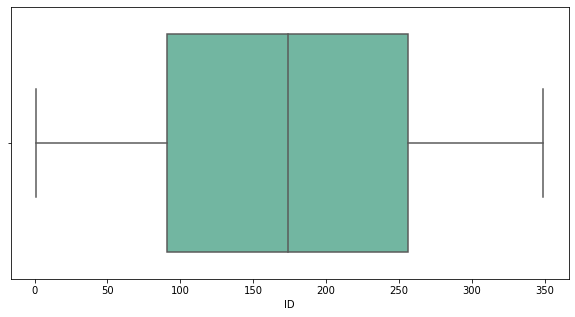

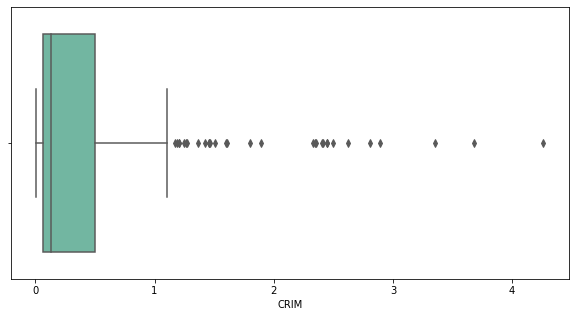

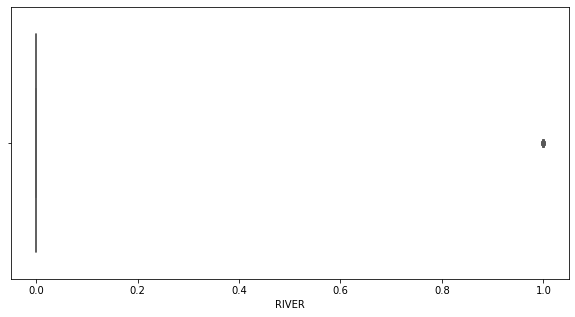

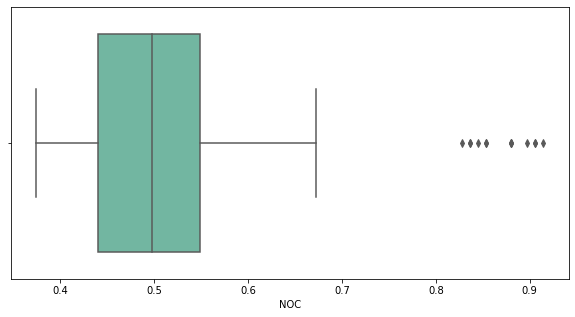

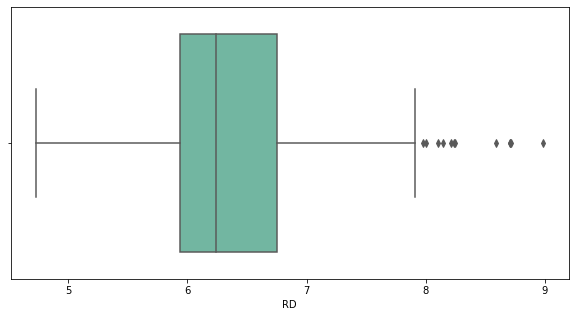

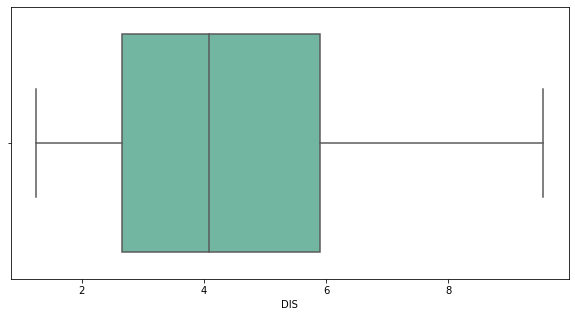

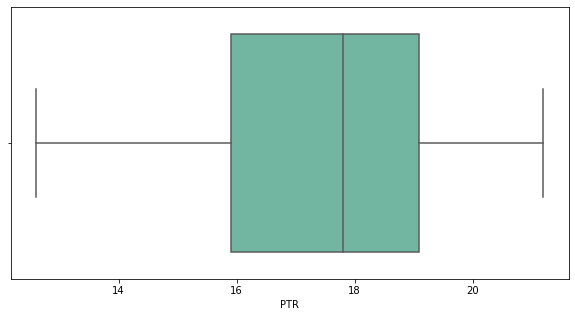

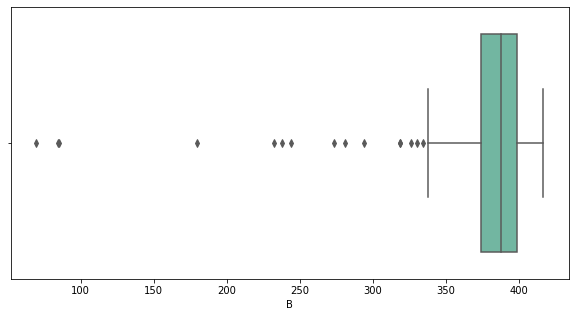

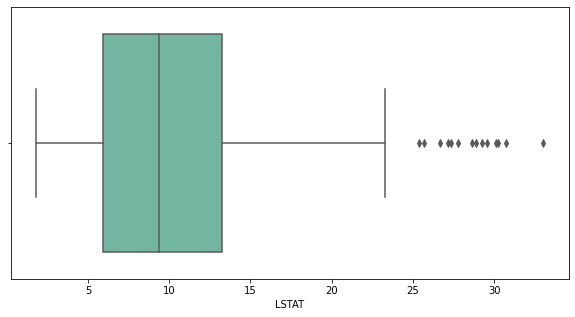

In [56]:
#set dimensions for better visualization with ax in subplot
#all features are numerical. so go ahead with a for loop and get a boxplot for each

for i in X_train:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.boxplot(X_train[i], orient='h',palette='Set2') 
    plt.show()

* 'CRIM': highly right skewed.all non zero positive values. 
* 'RIVER': Almost all the values are zero (Categorial variable). 
* 'NOC' : Right skewed. all non zero positive values. log transformation.
* 'RD' : Right skewed. all non zero positive values. log transformation.
* 'DIS' : Not skewed
* 'PTR' : Not skewed
* 'B' : Highly left skewed
* 'LSTAT':  Highly right skewed. all non zero positive values. log transformation.

Let us go for log transformation for 'CRIM','NOC','RD','LSTAT'

0.4172075142857148


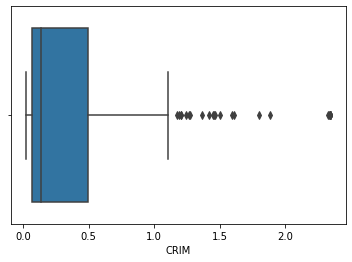

In [57]:
X_train['CRIM']=winsorize(X_train['CRIM'],limits=(0.05,0.05))
sns.boxplot(X_train['CRIM'])
print(X_train['CRIM'].mean())

0.4172075142857148


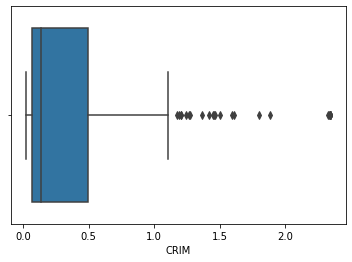

In [58]:
X_train['CRIM']=winsorize(X_train['CRIM'],limits=(0.05,0.05))
sns.boxplot(X_train['CRIM'])
print(X_train['CRIM'].mean())